In [21]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [22]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.15.0



In [23]:
!git clone https://github.com/tensorflow/examples.git

fatal: destination path 'examples' already exists and is not an empty directory.


In [24]:
os.listdir('images/')

['food_c101_n1000_r384x384x3.h5',
 'food_c101_n10099_r32x32x1.h5',
 'food_c101_n10099_r32x32x3.h5',
 'food_c101_n10099_r64x64x1.h5',
 'food_c101_n10099_r64x64x3.h5',
 'food_test_c101_n1000_r128x128x1.h5',
 'food_test_c101_n1000_r128x128x3.h5',
 'food_test_c101_n1000_r32x32x1.h5',
 'food_test_c101_n1000_r32x32x3.h5',
 'food_test_c101_n1000_r64x64x1.h5',
 'food_test_c101_n1000_r64x64x3.h5',
 'images',
 'meta',
 'test',
 'test_mini',
 'train',
 'train_mini']

In [25]:
os.listdir('images/images/')

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

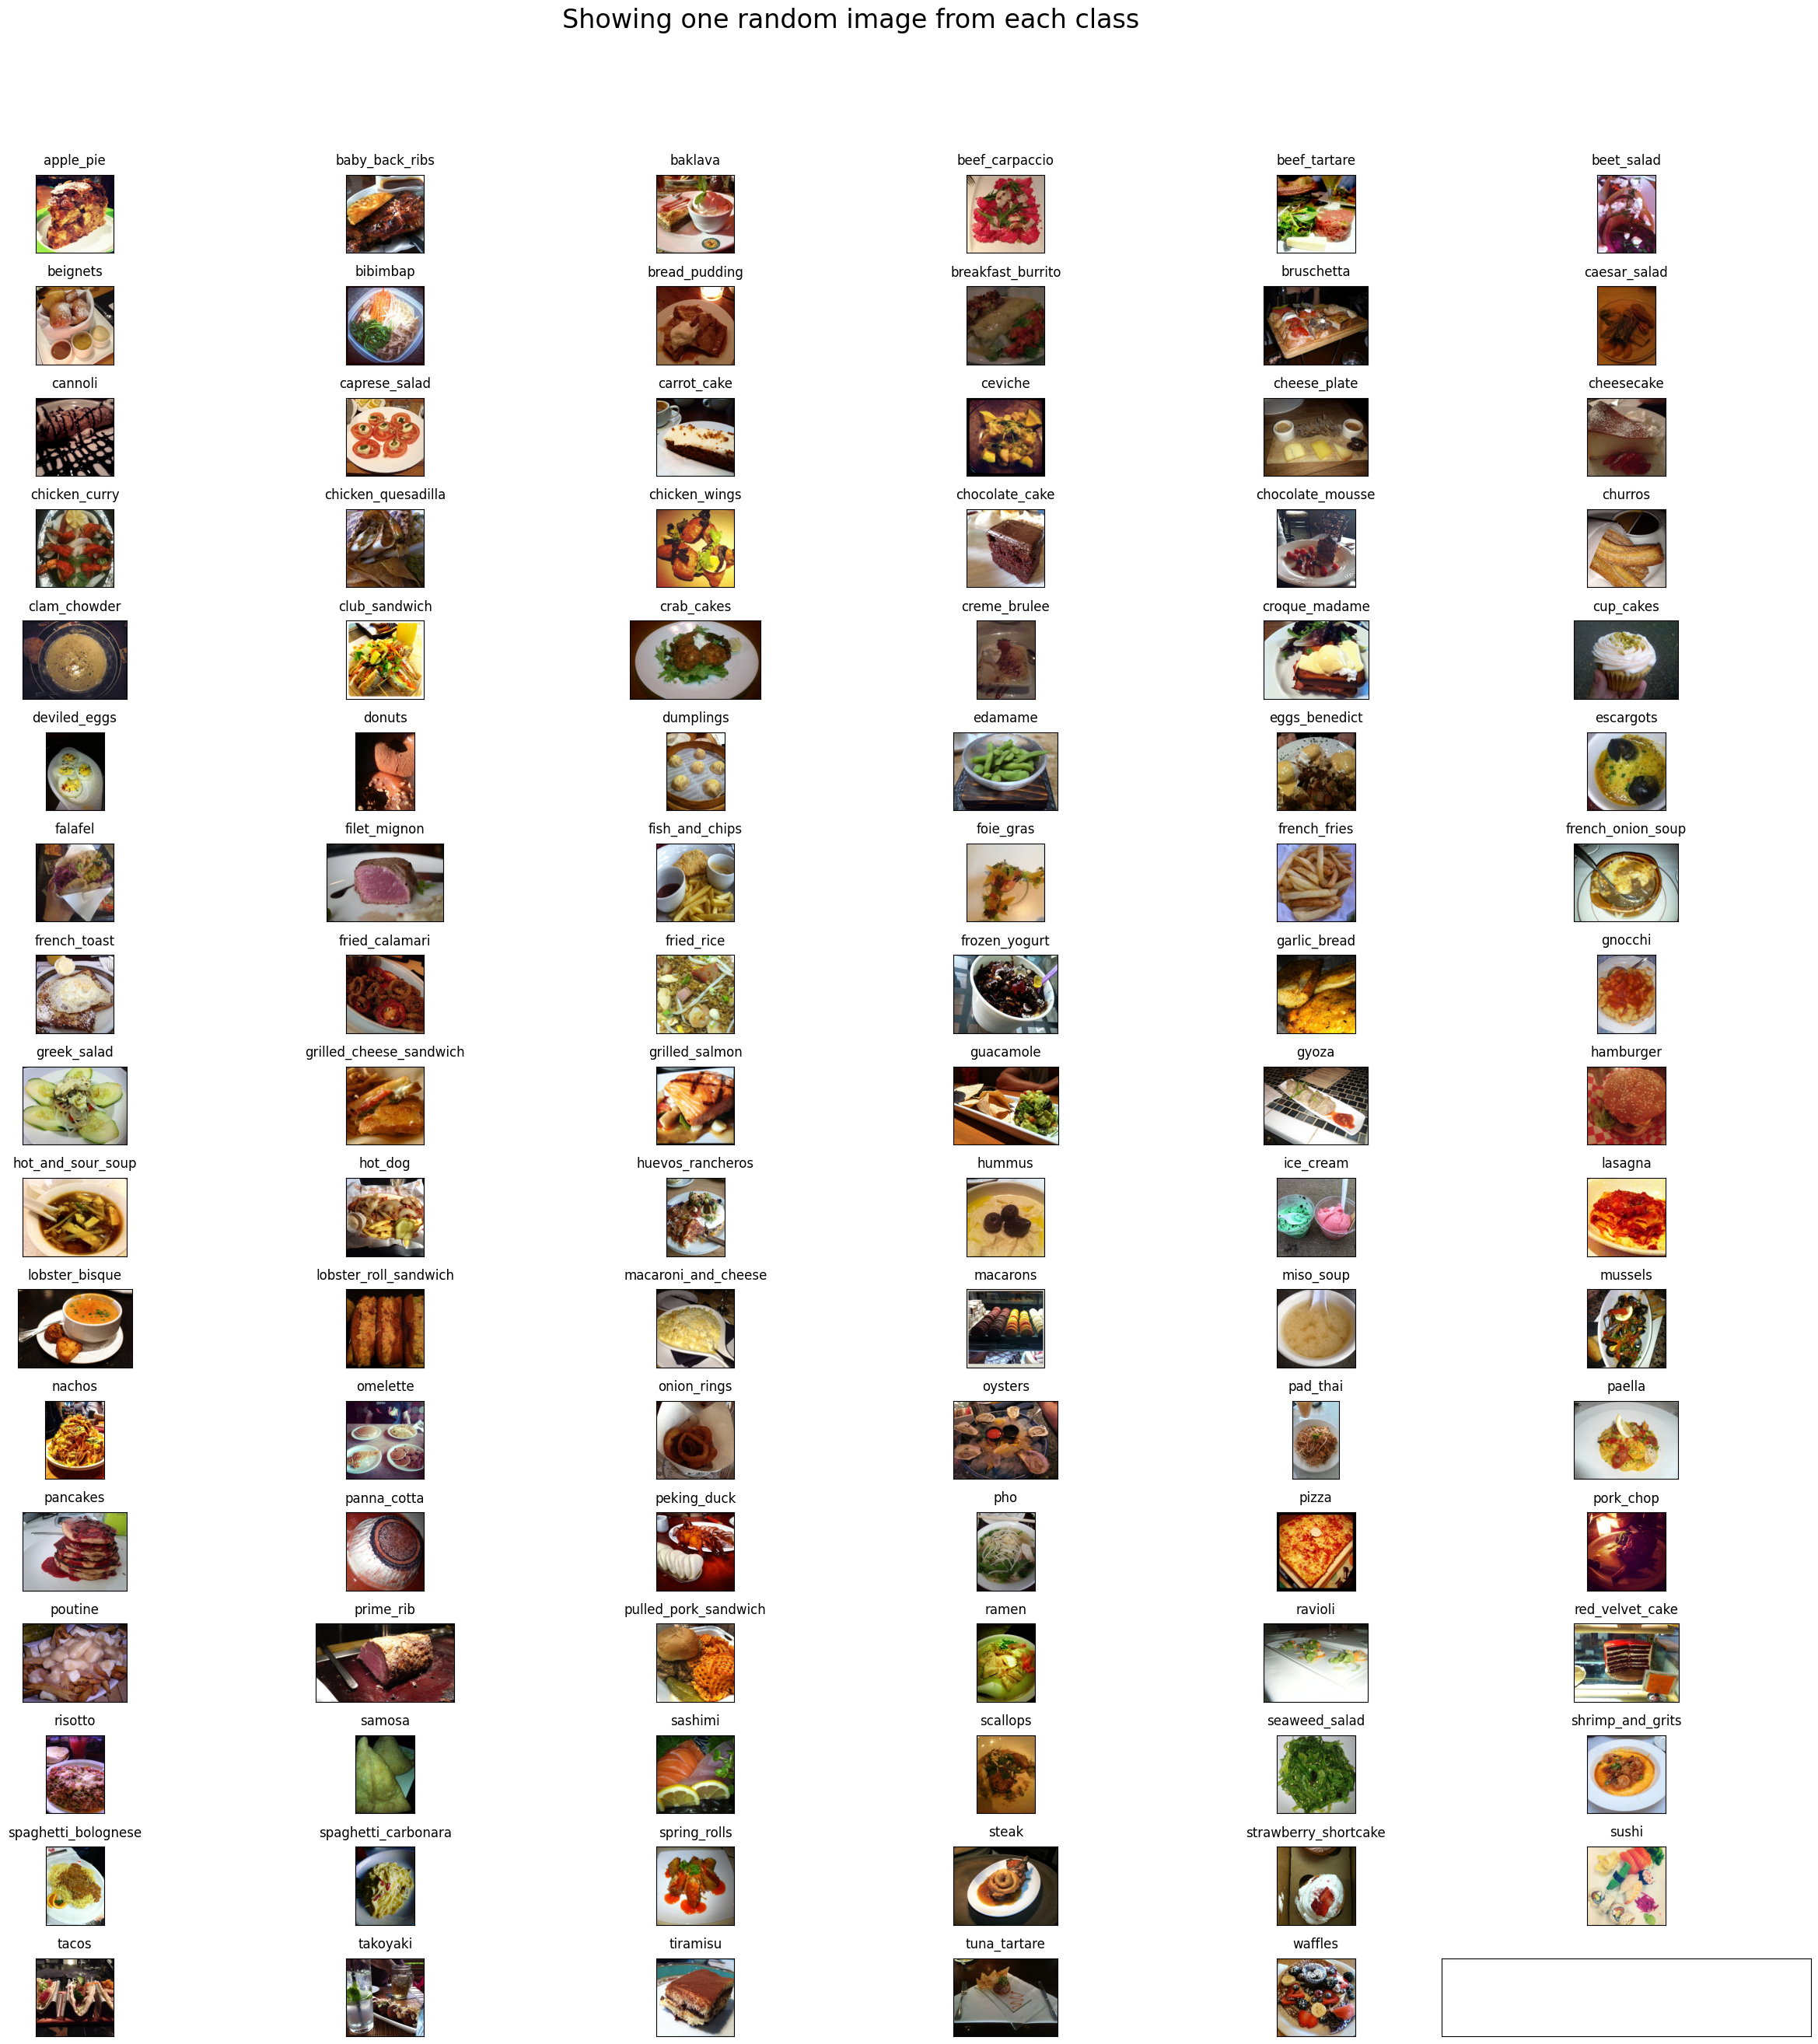

In [26]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "images/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [28]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [7]:
print("Creating train data...")
prepare_data('images/meta/meta/train.txt', 'images/images', 'images/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [29]:
print("Creating test data...")
prepare_data('images/meta/meta/test.txt', 'images/images', 'images/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [30]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("images/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [31]:
test_files = sum([len(files) for i, j, files in os.walk("images/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


In [8]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [9]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [10]:
# picking 3 food items and generating separate data folders for the same
food_list = ['samosa','pizza','omelette']
src_train = 'images/train'
dest_train = 'images/train_mini'
src_test = 'images/test'
dest_test = 'images/test_mini'

In [17]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [35]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("images/train_mini")])
print(train_files)

Total number of samples in train folder
8250


In [19]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [36]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("images/test_mini")])
print(test_files)

Total number of samples in test folder
2750


In [98]:
def train_model(n_classes, num_epochs, nb_train_samples, nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = 'images/train_mini'
  validation_data_dir = 'images/test_mini'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit(train_generator,
                      steps_per_epoch = nb_train_samples//batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples//batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [62]:
# Train the model with data from 3 classes
n_classes = 3
epochs = 5
nb_train_samples = train_files
nb_validation_samples = test_files
print(n_classes, epochs, nb_validation_samples, nb_train_samples)

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

3 5 25250 75750


In [100]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


# plot_accuracy(history,'FOOD101-Inceptionv3')
# plot_loss(history,'FOOD101-Inceptionv3')

In [27]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_3class.hdf5',compile = False)

CPU times: total: 1.39 s
Wall time: 6.17 s


In [63]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
  

1/1 [==============================] - 1s 1s/step


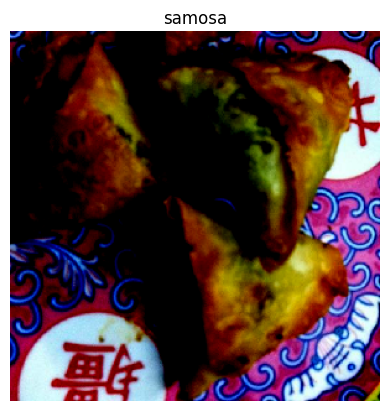

1/1 [==============================] - 0s 81ms/step


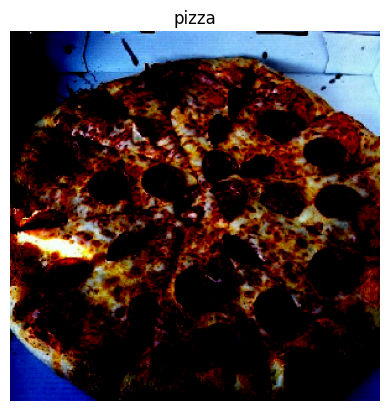

1/1 [==============================] - 0s 83ms/step


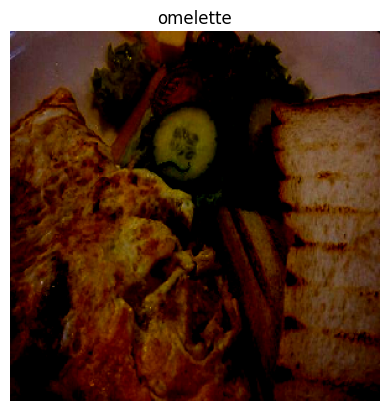

In [30]:
# Make a list of images and test the trained model
images = []
imagepath = '/content/examples/community/en/multi_class_classification/images/'
images.append("./images/test_mini/samosa/1009326.jpg")
images.append("./images/test_mini/pizza/1001116.jpg")
images.append("./images/test_mini/omelette/1019294.jpg")
predict_class(model_best, images, True)

In [91]:
def pick_n_random_classes(n):
  random.seed(9000)
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  print("These are the randomly picked food classes we will be training the model on...\n", food_list)
  return food_list

In [93]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 20
food_list = pick_n_random_classes(20)

These are the randomly picked food classes we will be training the model on...
 ['beef_tartare', 'bread_pudding', 'breakfast_burrito', 'chicken_curry', 'chocolate_mousse', 'churros', 'club_sandwich', 'crab_cakes', 'french_fries', 'french_toast', 'fried_rice', 'garlic_bread', 'hot_and_sour_soup', 'hot_dog', 'ice_cream', 'lasagna', 'macarons', 'oysters', 'pizza', 'takoyaki']


In [94]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into beef_tartare
Copying images into bread_pudding
Copying images into breakfast_burrito
Copying images into chicken_curry
Copying images into chocolate_mousse
Copying images into churros
Copying images into club_sandwich
Copying images into crab_cakes
Copying images into french_fries
Copying images into french_toast
Copying images into fried_rice
Copying images into garlic_bread
Copying images into hot_and_sour_soup
Copying images into hot_dog
Copying images into ice_cream
Copying images into lasagna
Copying images into macarons
Copying images into oysters
Copying images into pizza
Copying images into takoyaki


In [95]:
print("Total number of samples in train folder")
train_files2 = sum([len(files) for i, j, files in os.walk("images/train_mini")])
print(train_files2)

Total number of samples in train folder
15000


In [96]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into beef_tartare
Copying images into bread_pudding
Copying images into breakfast_burrito
Copying images into chicken_curry
Copying images into chocolate_mousse
Copying images into churros
Copying images into club_sandwich
Copying images into crab_cakes
Copying images into french_fries
Copying images into french_toast
Copying images into fried_rice
Copying images into garlic_bread
Copying images into hot_and_sour_soup
Copying images into hot_dog
Copying images into ice_cream
Copying images into lasagna
Copying images into macarons
Copying images into oysters
Copying images into pizza
Copying images into takoyaki


In [97]:
print("Total number of samples in test folder")
test_files2 = sum([len(files) for i, j, files in os.walk("images/test_mini")])
print(test_files2)

Total number of samples in test folder
5000


In [99]:
# Train the model with data from 3 classes
n_classes = 20
epochs = 5
nb_train_samples = train_files2
nb_validation_samples = test_files2

print(n_classes, epochs, nb_validation_samples, nb_train_samples)
history, class_map_11 = train_model(n_classes, epochs,nb_train_samples, nb_validation_samples)
print(class_map_11)

20 5 5000 15000
Found 15000 images belonging to 20 classes.
Found 5000 images belonging to 20 classes.
Epoch 1/5
937/937 [==============================] - ETA: 0s - loss: 2.6891 - accuracy: 0.2914
Epoch 1: val_loss improved from inf to 1.81893, saving model to bestmodel_20class.hdf5


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


937/937 [==============================] - 1872s 2s/step - loss: 2.6891 - accuracy: 0.2914 - val_loss: 1.8189 - val_accuracy: 0.6268
Epoch 2/5
937/937 [==============================] - ETA: 0s - loss: 1.7343 - accuracy: 0.5798
Epoch 2: val_loss improved from 1.81893 to 1.05708, saving model to bestmodel_20class.hdf5
937/937 [==============================] - 1799s 2s/step - loss: 1.7343 - accuracy: 0.5798 - val_loss: 1.0571 - val_accuracy: 0.7712
Epoch 3/5
937/937 [==============================] - ETA: 0s - loss: 1.3014 - accuracy: 0.6797
Epoch 3: val_loss improved from 1.05708 to 0.80029, saving model to bestmodel_20class.hdf5
937/937 [==============================] - 1796s 2s/step - loss: 1.3014 - accuracy: 0.6797 - val_loss: 0.8003 - val_accuracy: 0.8281
Epoch 4/5
937/937 [==============================] - ETA: 0s - loss: 1.1023 - accuracy: 0.7358
Epoch 4: val_loss improved from 0.80029 to 0.69288, saving model to bestmodel_20class.hdf5
937/937 [==============================] - 

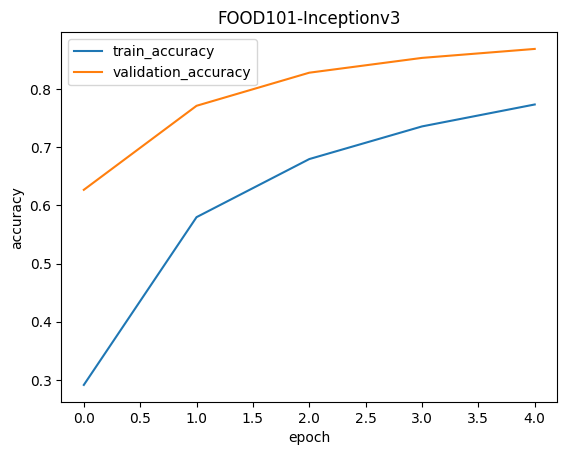

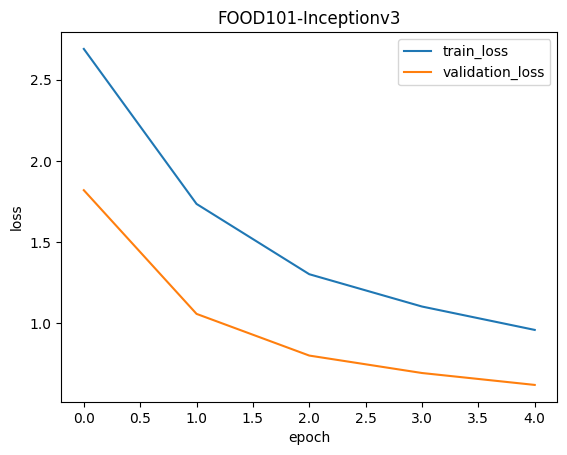

In [101]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [102]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_20class.hdf5',compile = False)

CPU times: total: 1.47 s
Wall time: 1min 52s


1/1 [==============================] - 5s 5s/step


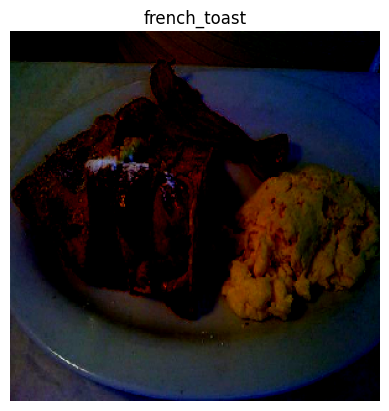

1/1 [==============================] - 3s 3s/step


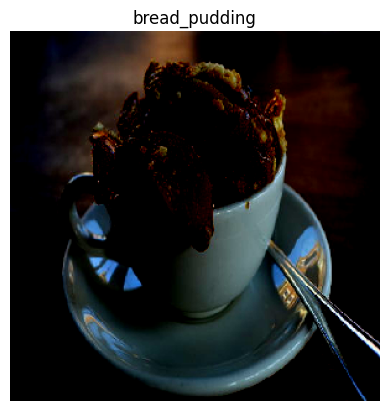

1/1 [==============================] - 3s 3s/step


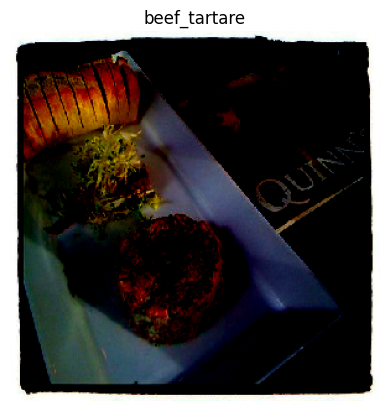

In [104]:
# Make a list of downloaded images and test the trained model
images = []
images.append("./images/test_mini/french_toast/100864.jpg")
images.append("./images/test_mini/bread_pudding/1042213.jpg")
images.append("./images/test_mini/beef_tartare/1030025.jpg")
# images.append()
predict_class(model_best, images, True)